#Exploratory Data Analysis

We first import the relevant libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

warnings.filterwarnings('ignore')
%matplotlib inline

#Loading in data

In [ ]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 74 kB 1.5 MB/s 
     |████████████████████████████████| 4.2 MB 15.4 MB/s 
     |████████████████████████████████| 150 kB 31.6 MB/s 
     |████████████████████████████████| 49 kB 338 kB/s 
     |████████████████████████████████| 113 kB 24.8 MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-18njji59/lxml_e4274df7e4074525aef22e64ebec7ee1/setup.py'"'"'; __file__='"'"'/tmp/pip-install-18njji59/lxml_e4274df7e4074525aef22e64ebec7ee1/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-kxjeodij/install-record.txt --s

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "ayushrauniyar13" 
os.environ['KAGGLE_KEY'] = "0b43511ef3d2e3caa964df7182466aec"

In [ ]:
!kaggle datasets download -d zygmunt/goodbooks-10k --unzip

  0% 0.00/11.6M [00:00<?, ?B/s]
100% 11.6M/11.6M [00:00<00:00, 205MB/s]


In [ ]:
dataset = pd.read_csv('ratings.csv')

In [ ]:
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [ ]:
 from sklearn import preprocessing

In [ ]:
def str2number(c):
    label_end = preprocessing.LabelEncoder()
    dataset[c] = label_end.fit_transform(dataset[c])
    dataset[c].unique()
for c in dataset.columns:
    str2number(c)

In [ ]:
dataset.shape

(981756, 3)

In [ ]:
dataset.head()

,book_id,user_id,rating
0,0,313,4
1,0,438,2
2,0,587,4
3,0,1168,3
4,0,1184,3


Spliting Data into Train data and Test data

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [ ]:
train.head()

,book_id,user_id,rating
341848,3422,4607,1
964349,9810,36372,4
645459,6484,2956,3
74960,749,42399,2
358670,3590,36885,4


In [ ]:
test.head()

,book_id,user_id,rating
646451,6494,19642,4
614851,6174,8562,3
974393,9919,52109,2
21471,214,33863,4
272540,2727,16586,2


In [ ]:
n_users = len(dataset.user_id.unique())
n_users

53424

In [ ]:
n_product = len(dataset.book_id.unique())
n_product

10000

#Creating dot product model

In [ ]:
# creating book embedding path
product_input = Input(shape=[1], name="Product-Input")
product_embedding = Embedding(n_product+1, 5, name="Product-Embedding")(product_input)
product_vec = Flatten(name="Flatten-Products")(product_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])
model5 = Model([user_input, product_input], prod)
model5.compile('adam', 'mean_squared_error')

Epoch 1/5
24544/24544 [==============================] - 126s 5ms/step - loss: 7.9041
Epoch 2/5
24544/24544 [==============================] - 109s 4ms/step - loss: 2.7842
Epoch 3/5
24544/24544 [==============================] - 108s 4ms/step - loss: 1.2923
Epoch 4/5
24544/24544 [==============================] - 106s 4ms/step - loss: 0.9492
Epoch 5/5
24544/24544 [==============================] - 106s 4ms/step - loss: 0.8098


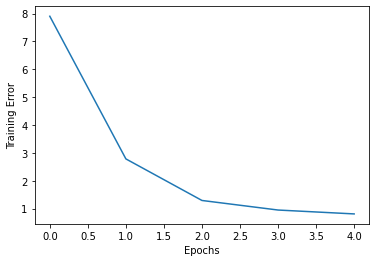

In [ ]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model5 = load_model('regression_model.h5')
else:
    history = model5.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
    model5.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [ ]:
model5.evaluate([test.user_id, test.book_id], test.rating)

6136/6136 [==============================] - 13s 2ms/step - loss: 0.9849


0.98491370677948

In [ ]:
predictions = model5.predict([test.user_id, test.book_id])
[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[4.1615496] 4
[2.7771242] 3
[2.6191149] 2
[3.673883] 4
[2.5526056] 2
[2.9597173] 2
[2.4530528] 2
[3.9930782] 3
[3.2549086] 2
[2.6966743] 4


[None, None, None, None, None, None, None, None, None, None]

In [ ]:
predictions.shape


(196352, 1)

Checking Accuracy of the Model

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test.rating,predictions))
print(rms)

0.9924273687942902


# Making Recommendations 


Creating dataset for making recommendations for the user.

In [ ]:
book_data = np.array(list(set(dataset.book_id)))
book_data[:5]

array([0, 1, 2, 3, 4])

In [ ]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [ ]:
predictions = model5.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([7880, 7580, 9079, 9248, 9274])

Printing Predicted Score

In [ ]:
predictions[recommended_book_ids]

array([2.428609 , 2.1659203, 2.1494753, 2.1305325, 2.0217795],
      dtype=float32)

In [ ]:
book_data = pd.read_csv('books.csv')

In [ ]:
Required_book_data = book_data[["id","book_id","isbn","authors"]]
Required_book_data.head()


,id,book_id,isbn,authors
0,1,2767052,439023483,Suzanne Collins
1,2,3,439554934,"J.K. Rowling, Mary GrandPré"
2,3,41865,316015849,Stephenie Meyer
3,4,2657,61120081,Harper Lee
4,5,4671,743273567,F. Scott Fitzgerald


In [ ]:
from sklearn import preprocessing

In [ ]:
def str2number(c):
    label_end = preprocessing.LabelEncoder()
    dataset[c] = label_end.fit_transform(dataset[c])
    dataset[c].unique()
for c in dataset.columns:
    str2number(c)

Printing Information related to predicted book_id.

In [ ]:
Required_book_data[Required_book_data['id'].isin(recommended_book_ids)]

,id,book_id,isbn,authors
7579,7580,9366879,545141028,"Tom Sniegoski, Jeff Smith, Thomas E. Sniegoski..."
7879,7880,1301153,60724617,Meg Cabot
9078,9079,450836,1573458716,Gerald N. Lund
9247,9248,6630751,NaN,Andrew Peterson
9273,9274,17853024,7331908,Bernard Cornwell
